# Modelo de clasificación de Alopecia androgénica

Origen del dataset: hair-loss Classification Model by uze (2024). https://universe.roboflow.com/uze/hair-loss-nq8hh/dataset/1#.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from PIL import Image
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import torchvision
import torchvision.transforms as transforms

In [2]:
df_train = pd.read_csv('data/train/_classes.csv')
df_val = pd.read_csv('data/valid/_classes.csv')
df_test = pd.read_csv('data/test/_classes.csv')

df_train.head()

,filename,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6,LEVEL_7
0,55-Front_jpg.rf.8e33204ae51619dbc14b2c05374a58...,0,1,0,0,0,0
1,27-Left_jpg.rf.9078d1b22afbfc8cef9a19dbed304c2...,0,0,1,0,0,0
2,39-Back_jpg.rf.8d7360446c976ce0e1419638d9f6003...,0,0,1,0,0,0
3,23-Front_jpg.rf.8fc70587a0b731a859bfe4cdd11784...,0,0,0,1,0,0
4,29-Left_jpg.rf.8f3d12809a8662891b1a02d4578c5cb...,0,0,0,0,1,0


In [3]:
df_train.info()
df_val.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1294 non-null   object
 1    LEVEL_2  1294 non-null   int64 
 2    LEVEL_3  1294 non-null   int64 
 3    LEVEL_4  1294 non-null   int64 
 4    LEVEL_5  1294 non-null   int64 
 5    LEVEL_6  1294 non-null   int64 
 6    LEVEL_7  1294 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 70.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  133 non-null    object
 1    LEVEL_2  133 non-null    int64 
 2    LEVEL_3  133 non-null    int64 
 3    LEVEL_4  133 non-null    int64 
 4    LEVEL_5  133 non-null    int64 
 5    LEVEL_6  133 non-null    int64 
 6    LEVEL_7  133 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 7.4+ KB
<clas

In [4]:
print(df_train.isnull().sum().sum())
print(df_val.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0
0


**Findings**  
None of the three datasets contain any null values.

In [5]:
def plot_value_counts(df, column, ax_num, title):
    cols = df.columns.tolist()
    cols.remove(column)

    counts = df[cols].sum()
    sns.barplot(x=counts.index, y=counts.values, palette='terrain', hue=counts.index, ax=ax_num)
    ax_num.set_xlabel(column)
    ax_num.set_ylabel('Count')
    ax_num.set_title(title)

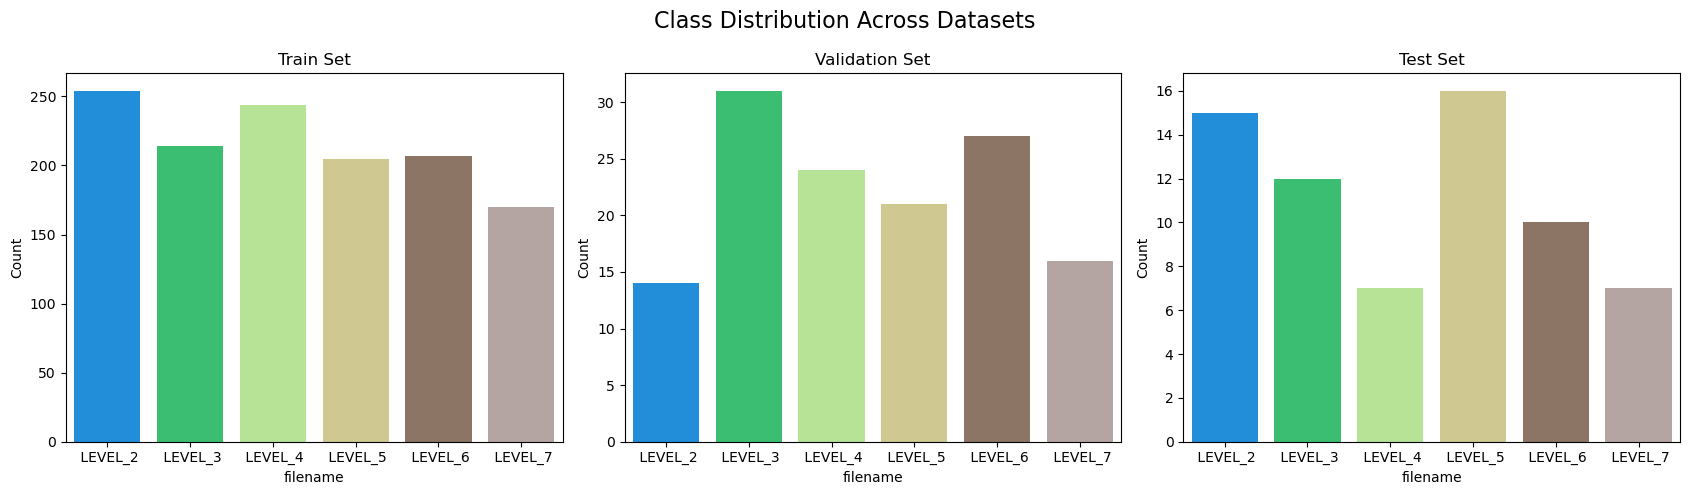

In [6]:
fig, ax = plt.subplot_mosaic(
    mosaic=[[0, 1, 2]],
    figsize=(17, 5)
)
plot_value_counts(df_train, 'filename', ax[0], 'Train Set')
plot_value_counts(df_val, 'filename', ax[1], 'Validation Set')
plot_value_counts(df_test, 'filename', ax[2], 'Test Set')
plt.suptitle('Class Distribution Across Datasets', fontsize=16)
plt.tight_layout()
plt.show()

**Findings**  
While the train set has balanced labels, both validation and test set don't, having the most common class more than twice the size of the rarest.

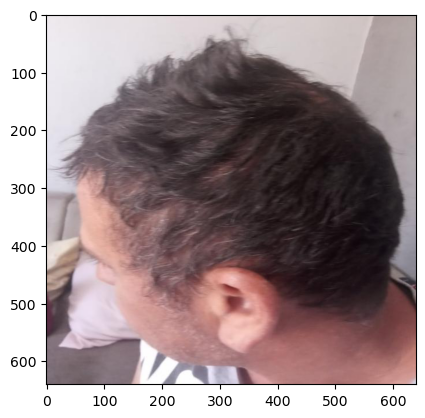

In [7]:
img = Image.open("data/train/" + df_train["filename"][np.random.randint(len(df_train))])
plt.imshow(img)

**Findings**  
Images from the training set had already been augmented by fliping them both horizontally and vertically

In [ ]:
for i in range(len(df_train)):
    img = Image.open(f'data/train/{df_train["filename"][i]}')
    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"

for i in range(len(df_val)):
    img = Image.open(f'data/valid/{df_val["filename"][i]}')
    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"

for i in range(len(df_test)):
    img = Image.open(f'data/test/{df_test["filename"][i]}')
    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"

'\nfor i in range(len(df_train)):\n    img = Image.open(f\'data/train/{df_train["filename"][i]}\')\n    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"\n\nfor i in range(len(df_val)):\n    img = Image.open(f\'data/valid/{df_val["filename"][i]}\')\n    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"\n\nfor i in range(len(df_test)):\n    img = Image.open(f\'data/test/{df_test["filename"][i]}\')\n    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"\n'

**Findings**  
All images have the same size and are RGB

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

X_train_tensor = torch.stack([transform(Image.open(f'data/train/{fname}')) for fname in df_train['filename']])
y_train_tensor = torch.tensor(df_train.drop(columns=['filename']).values, dtype=torch.float32)

X_train_tensor.shape, y_train_tensor.shape

(torch.Size([1294, 3, 512, 512]), torch.Size([1294, 6]))

In [10]:
X_val_tensor = torch.stack([transform(Image.open(f'data/valid/{fname}')) for fname in df_val['filename']])
y_val_tensor = torch.tensor(df_val.drop(columns=['filename']).values, dtype=torch.float32)

X_test_tensor = torch.stack([transform(Image.open(f'data/test/{fname}')) for fname in df_test['filename']])
y_test_tensor = torch.tensor(df_test.drop(columns=['filename']).values, dtype=torch.float32)

In [11]:
torch.save(X_train_tensor, 'data/X_train_data.pt')
torch.save(y_train_tensor, 'data/y_train_data.pt')
torch.save(X_val_tensor, 'data/X_val_data.pt')
torch.save(y_val_tensor, 'data/y_val_data.pt')
torch.save(X_test_tensor, 'data/X_test_data.pt')
torch.save(y_test_tensor, 'data/y_test_data.pt')

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [13]:
# Clean memory allocated on GPU 
torch.cuda.empty_cache()

In [14]:
X_train_tensor = torch.load('data/X_train_data.pt').to(device)
y_train_tensor = torch.load('data/y_train_data.pt').to(device)
X_val_tensor = torch.load('data/X_val_data.pt').to(device)
y_val_tensor = torch.load('data/y_val_data.pt').to(device)
X_test_tensor = torch.load('data/X_test_data.pt').to(device)
y_test_tensor = torch.load('data/y_test_data.pt').to(device)

In [15]:
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
Val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Train_dataset[:][0].shape, Train_dataset[:][1].shape

(torch.Size([1294, 3, 512, 512]), torch.Size([1294, 6]))

In [16]:
Train_dataset[0][0].is_cuda

True

In [36]:
class AlopeciaModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=6)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 125 * 125, 128),
            nn.ReLU(),
            nn.Dropout(0.33),
            nn.Linear(128, 6)
        )
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.sequential(x)
        return x


In [37]:
def entrenar_modelo(model, train_dataset, X_tensor_val, y_tensor_val, epochs=250, batch_size=32, learning_rate=0.0001, scheduler=True, paciencia_scheduler=5, early_stopping=True, paciencia_early_stopping=15, show=True):
    """
    Entrena el modelo GRU con los datos de entrenamiento.
    
    Parámetros:
    - model (nn.Module): Instancia del modelo GRU.
    - train_dataset (TensorDataset): Dataset de entrenamiento.
    - X_tensor_val (Tensor): Tensor de características de validación.
    - y_tensor_val (Tensor): Tensor de etiquetas de validación.
    - epochs (int): Número de épocas para entrenar.
    - batch_size (int): Tamaño del lote para el entrenamiento.
    - learning_rate (float): Tasa de aprendizaje para el optimizador.
    - scheduler (bool): Indica si se debe utilizar un programador de tasa de aprendizaje.
    - paciencia_scheduler (int): Número de épocas para esperar antes de reducir la tasa de aprendizaje.
    - early_stopping (bool): Indica si se debe utilizar la detención temprana.
    - paciencia_early_stopping (int): Número de épocas para esperar antes de detener el entrenamiento.
    - show (bool): Indica si se deben mostrar los mensajes de entrenamiento.

    Devuelve:
    - model (nn.Module): Modelo entrenado.
    """
    torch.manual_seed(27)
    torch.cuda.empty_cache()
    
    model = model.to(device)
    X_tensor_val = X_tensor_val.to(device)
    y_tensor_val = y_tensor_val.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,)
    criterion = nn.BCEWithLogitsLoss()
    if scheduler:
        step_lr = optim.lr_scheduler.StepLR(optimizer, step_size=paciencia_scheduler, gamma=0.75)

    if early_stopping:
        mejor_perdida = float('inf')
        epochs_sin_mejorar = 0
        mejor_modelo = None

    generador = torch.Generator()
    generador.manual_seed(27)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generador)

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        if scheduler:
            step_lr.step()

        if early_stopping:
            with torch.no_grad():
                model.eval()
                val_outputs = model(X_tensor_val)
                val_loss = criterion(val_outputs.squeeze(), y_tensor_val)
           
            if val_loss.item() < mejor_perdida:
                mejor_perdida = val_loss.item()
                epochs_sin_mejorar = 0
                mejor_modelo = copy.deepcopy(model.state_dict())
            else:
                epochs_sin_mejorar += 1

                if epochs_sin_mejorar >= paciencia_early_stopping:
                    if show:
                        print(f'No se observó mejora en {paciencia_early_stopping} épocas. Deteniendo entrenamiento.')

                    model.load_state_dict(mejor_modelo)
                    return model

        if show and ((epoch + 1) % 10 == 0):
            print(f'Época [{epoch + 1}/{epochs}], Pérdida: {loss.item():.4f}')
            if early_stopping:
                print(f'Mejor pérdida de validación actual:{mejor_perdida:.4f}')
    if early_stopping and mejor_modelo:
        model.load_state_dict(mejor_modelo)
    return model

In [38]:
def evaluar_modelo(y_test, logits):

    y_test = y_test.cpu().numpy()
    logits = logits.cpu().numpy()

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()

    # Convertir one-hot a etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Predicción por clase más probable
    y_pred = np.argmax(probs, axis=1)

    # Reporte de clasificación
    print(classification_report(y_true, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', ax=ax[0])
    ax[0].set_xlabel('Predicción')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Matriz de Confusión')

    # ROC multiclase
    roc_auc = roc_auc_score(y_test, probs, average='macro', multi_class='ovr')
    fpr, tpr, _ = roc_curve(y_test.ravel(), probs.ravel())
    ax[1].plot(fpr, tpr, label=f'AUC (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set_xlabel('Tasa de Falsos Positivos')
    ax[1].set_ylabel('Tasa de Verdaderos Positivos')
    ax[1].set_title('Curva ROC')
    ax[1].legend()

    plt.show()


In [39]:
BolaDeCristal = AlopeciaModel()
BolaDeCristal = entrenar_modelo(BolaDeCristal, Train_dataset, X_val_tensor, y_val_tensor)

Época [10/250], Pérdida: 0.1853
Mejor pérdida de validación actual:0.3902
No se observó mejora en 15 épocas. Deteniendo entrenamiento.


              precision    recall  f1-score   support

           0       0.50      0.47      0.48        15
           1       0.27      0.50      0.35        12
           2       0.00      0.00      0.00         7
           3       0.60      0.38      0.46        16
           4       0.00      0.00      0.00        10
           5       0.20      0.43      0.27         7

    accuracy                           0.33        67
   macro avg       0.26      0.30      0.26        67
weighted avg       0.32      0.33      0.31        67



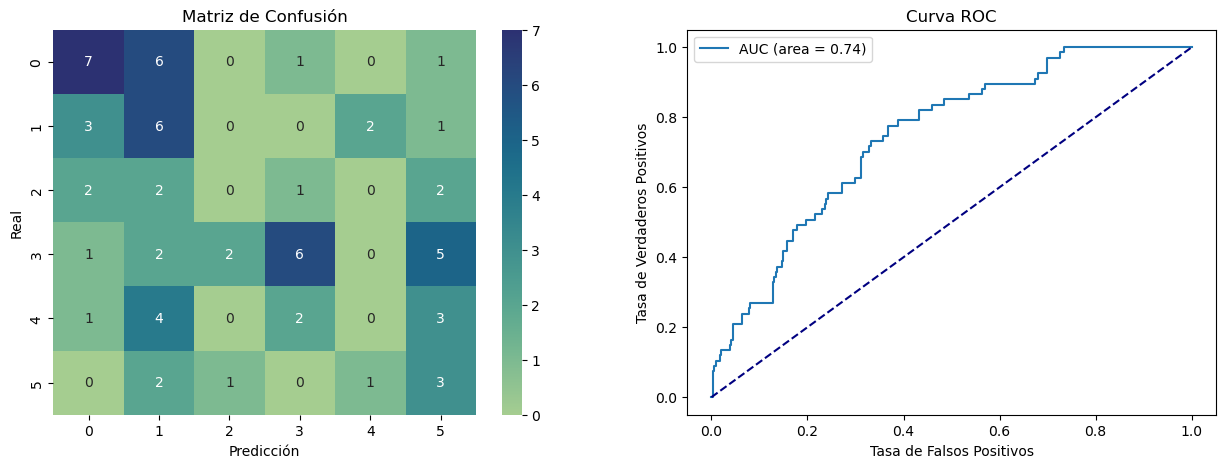

In [40]:
logits_test = BolaDeCristal(X_test_tensor).detach()
evaluar_modelo(y_test_tensor, logits_test)